# INTRODUCTION

School dropout and educational failure pose significant challenges to economic growth and societal well-being, directly impacting students, families, institutions, and the broader community. According to the **Education Data Initiative**, around **40% of undergraduate students** drop out before completing their degree. College dropouts face more financial challenges, earning an average of **35% less income** and experiencing a **20% higher unemployment rate** compared to their peers who graduate.

## Research Question:
1. **What factors contribute to student dropout or success, and how do they impact it?**

## Data

The dataset contains **4,424 records** with **35 attributes**, where each record represents an individual student. It includes information available at the time of student enrollment, along with demographic, socioeconomic, and macroeconomic data, as well as the students’ academic performance at the end of the first and second semesters.

- **Data Source:**  
Valentim Realinho, Jorge Machado, Luís Baptista, and Mónica V. Martins. *“Predict Students' Dropout and Academic Success”*. Zenodo, December 13, 2021. [https://doi.org/10.5281/zenodo.5777340](https://doi.org/10.5281/zenodo.5777340).

- **Data Description:**  
Realinho, Valentim, Jorge Machado, Luís Baptista, and Mónica V. Martins. 2022. *"Predicting Student Dropout and Academic Success"* Data 7, no. 11: 146. [https://doi.org/10.3390/data7110146](https://doi.org/10.3390/data7110146)


In [31]:
# Load packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
students = pd.read_csv('../data/dataset.csv')
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

# DATA CLEANING

This dataset is nearly clean thanks to the rigorous data preprocessing performed by the contributors of the data [Reference](https://www.mdpi.com/2306-5729/7/11/146). They've addressed anomalies, outliers, and missing values.

However, a few minor cleaning steps are still needed. First, modify some column names to make them more consistent and easier to work with later.

In [32]:
# Correct a column name that has a typo 
students.rename(columns={"Nacionality" : "Nationality",
                         "Mother's qualification" : "Mother_qualification",
                         "Father's qualification" : "Father_qualification",
                         "Mother's occupation" : "Mother_occupation",
                         "Father's occupation" : "Father_occupation",
                         "Age at enrollment" : "Age"}, inplace=True)

# Replace white space in column names with underscore
students.columns = students.columns.str.replace(' ', '_')

# Remove parenthesis
students.columns = students.columns.str.replace('(', '')
students.columns = students.columns.str.replace(')', '')
    

Change the data types of columns that should be categorical from ‘int’ to ‘category’ to ensure that classification models treat these columns as categorical data rather than numerical.

In [33]:
# Change data types of columns that should be categorical
col = ['Marital_status', 'Application_mode', 'Application_order', 'Course',
      'Daytime/evening_attendance', 'Previous_qualification', 'Nationality',
       'Mother_qualification', 'Father_qualification', 'Mother_occupation',
       'Father_occupation', 'Displaced', 'Educational_special_needs', 'Debtor',
       'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder',
      'International', 'Target']

students[col] = students[col].astype('category')

Text(0.5, 1.0, 'Proportion of Labels')

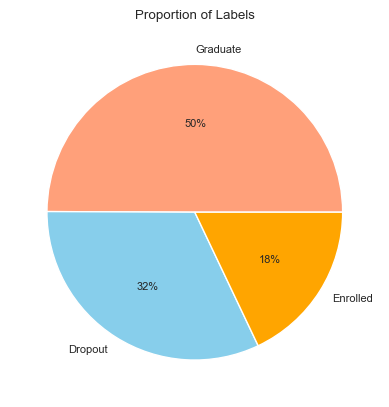

In [34]:
labels = students['Target'].value_counts().index
values = students['Target'].value_counts().values

plt.pie(values, labels=labels, colors=['lightsalmon', 'skyblue', 'orange'], autopct = '%1.0f%%')
plt.title('Proportion of Labels')

From the pie chart above we can see that the data is imbalanced: with about 50% of the labels are 'Graduate', 32% are 'Dropout', and 18% are 'Enrolled'.

The labels are string; hence will be encoded as ordinal data -- 0 represents 'Dropout', 1 represents 'Enrolled', and 2 represents 'Graduate' -- since most classification models only handle numeric values.

In [35]:
from sklearn.preprocessing import OrdinalEncoder

# Encode the labels as ordinal data (0 - 'Dropout', 1 - 'Enrolled', and 2 - 'Graduate') 
students['Target_encoded'] = OrdinalEncoder(categories = [['Dropout', 'Enrolled', 'Graduate']]).fit_transform(students[['Target']])

# Drop 'Target' variable
students.drop('Target', axis = 1, inplace = True)

## Exploratory Data Analysis

This dataset contains 34 features. An examination of the relationships between these features and the target variable, which is a three-class categorical data, will be conducted. Features that do not show any association with the target variable may be considered for removal from the modeling process.

### Chi-Square Independence Test for Categorical Variables

The Chi-Square independence test will be used to evaluate the association between the categorical variables and the dependent variable, following this hypothesis:

- **H0**: The two variables are independent.  
- **H1**: The two variables are dependent.  

The significance level (α) is set at 0.05. 

If the p-value is less than 0.05, the null hypothesis will be rejected in favor of the alternative hypothesis, indicating that the two variables are dependent. Conversely, if the p-value is greater than or equal to 0.05, the null hypothesis will not be rejected, suggesting that the two variables are independent.


In [36]:
from scipy.stats import chi2_contingency

# list of categorical features
cats = ['Marital_status', 'Application_mode', 'Application_order', 
        'Course','Daytime/evening_attendance', 'Previous_qualification', 
        'Nationality','Mother_qualification', 'Father_qualification', 
        'Mother_occupation', 'Father_occupation', 'Displaced', 
        'Educational_special_needs', 'Debtor','Tuition_fees_up_to_date', 
        'Gender', 'Scholarship_holder','International']

# Get the p-values from Chi-Square independence tests
p_value = []

for cat in cats:
    crosstable = pd.crosstab(index=students[cat],
                             columns=students['Target_encoded'])
    p = chi2_contingency(crosstable)[1]
    p_value.append(p)
    
chi2_result = pd.DataFrame({
    'Variable' : cats,
    'P_value' : [round(ele, 5) for ele in p_value]
})

chi2_result =  chi2_result.sort_values('P_value')
chi2_result

,Variable,P_value
0,Marital_status,0.00000
15,Gender,0.00000
14,Tuition_fees_up_to_date,0.00000
13,Debtor,0.00000
11,Displaced,0.00000
10,Father_occupation,0.00000
9,Mother_occupation,0.00000
16,Scholarship_holder,0.00000
8,Father_qualification,0.00000
5,Previous_qualification,0.00000


Most of the p-values obtained are close to zero, indicating a significant association between the features and the target variable. However, three variables—'Nationality,' 'International,' and 'Educational_special_needs'—exhibit high p-values of 0.24, 0.53, and 0.73, respectively. This suggests that there is no statistically significant association between these three features and the target variable. As a result, these variables will be excluded from the modeling process.


In [37]:
stud_selected = students.drop(['Nationality', 'International', 'Educational_special_needs'], 
                              axis = 1)  

### Spearman's Rank Correlation Between Numerical Features and the Label

A heatmap is utilized to visualize the Spearman's rank correlation between numerical features and the target variable. Spearman's rank correlation measures the strength and direction of monotonic association between two variables, effectively capturing both linear and nonlinear monotonic relationships.


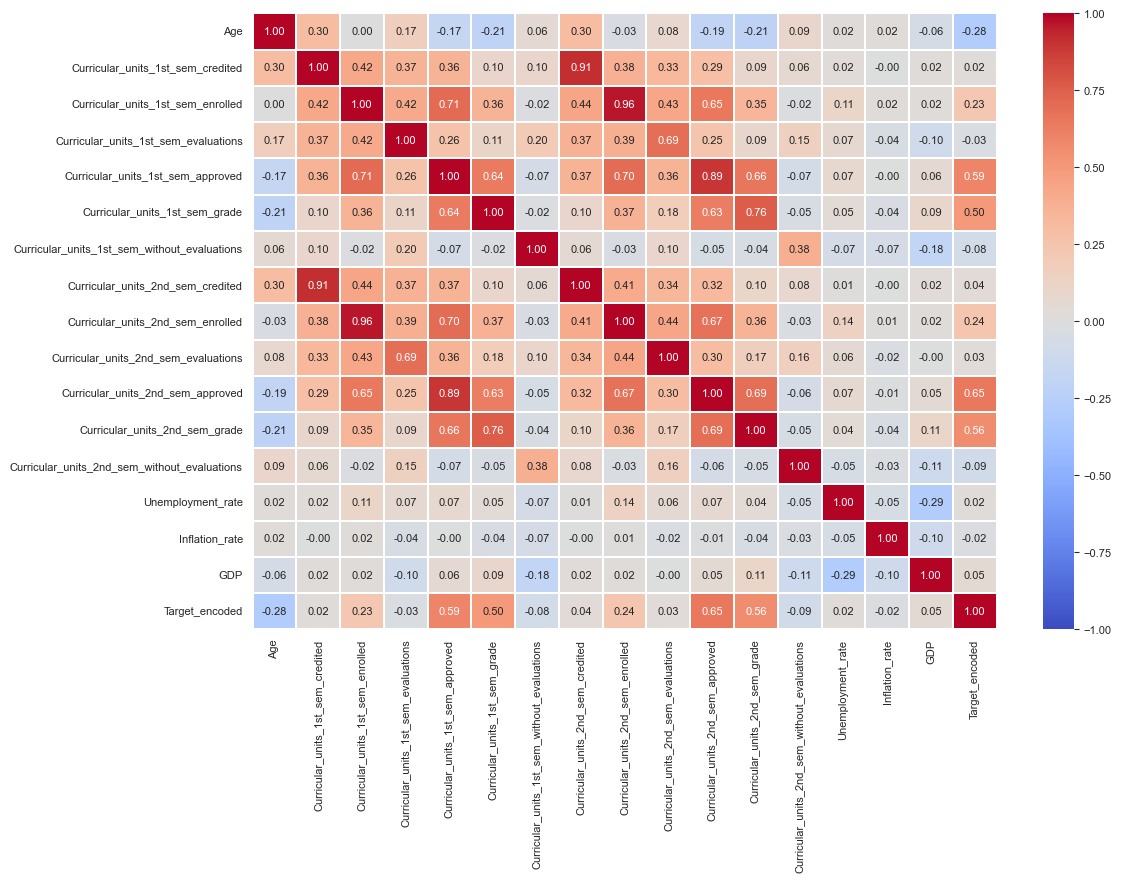

In [51]:


# Numeric features
num_features = students[['Age',
       'Curricular_units_1st_sem_credited',
       'Curricular_units_1st_sem_enrolled',
       'Curricular_units_1st_sem_evaluations',
       'Curricular_units_1st_sem_approved', 
       'Curricular_units_1st_sem_grade',
       'Curricular_units_1st_sem_without_evaluations',
       'Curricular_units_2nd_sem_credited',
       'Curricular_units_2nd_sem_enrolled',
       'Curricular_units_2nd_sem_evaluations',
       'Curricular_units_2nd_sem_approved', 
       'Curricular_units_2nd_sem_grade',
       'Curricular_units_2nd_sem_without_evaluations', 
       'Unemployment_rate', 'Inflation_rate', 'GDP', 'Target_encoded']]

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 8})
heatmap = sns.heatmap(num_features.corr(method='spearman'),
                      cmap = 'coolwarm', annot = True, fmt = '.2f', 
                      linewidths = .2, vmin = -1, vmax = 1, center = 0)
plt.show()

The heatmap illustrates that four features—`Curricular_units_2nd_sem_approved`, `Curricular_units_2nd_sem_grade`, `Curricular_units_1st_sem_approved`, and `Curricular_units_1st_sem_grade`—exhibit relatively high and positive correlations with the target label. Conversely, certain features such as `Unemployment_rate` and `Inflation_rate` display very low correlations.

Additionally, the heatmap indicates multicollinearity among the features related to curricular units. These features reflect students' academic performance at the end of the first and second semesters. To address this multicollinearity, the average values between the two semesters will be aggregated for a more streamlined analysis.


In [42]:
stud_selected['curri_avg_credited'] = stud_selected[['Curricular_units_1st_sem_credited', 'Curricular_units_2nd_sem_credited']].mean(axis=1)
stud_selected['curri_avg_enrolled'] = stud_selected[['Curricular_units_1st_sem_enrolled', 'Curricular_units_2nd_sem_enrolled']].mean(axis = 1)
stud_selected['curri_avg_evaluations'] = stud_selected[['Curricular_units_1st_sem_evaluations', 'Curricular_units_2nd_sem_evaluations']].mean(axis = 1)
stud_selected['curri_avg_approved'] = stud_selected[['Curricular_units_1st_sem_approved', 'Curricular_units_2nd_sem_approved']].mean(axis = 1)
stud_selected['curri_avg_grade'] = stud_selected[['Curricular_units_1st_sem_grade', 'Curricular_units_2nd_sem_grade']].mean(axis = 1)
stud_selected['curri_avg_without_evaluations'] = stud_selected[['Curricular_units_1st_sem_without_evaluations', 'Curricular_units_2nd_sem_without_evaluations']].mean(axis = 1)

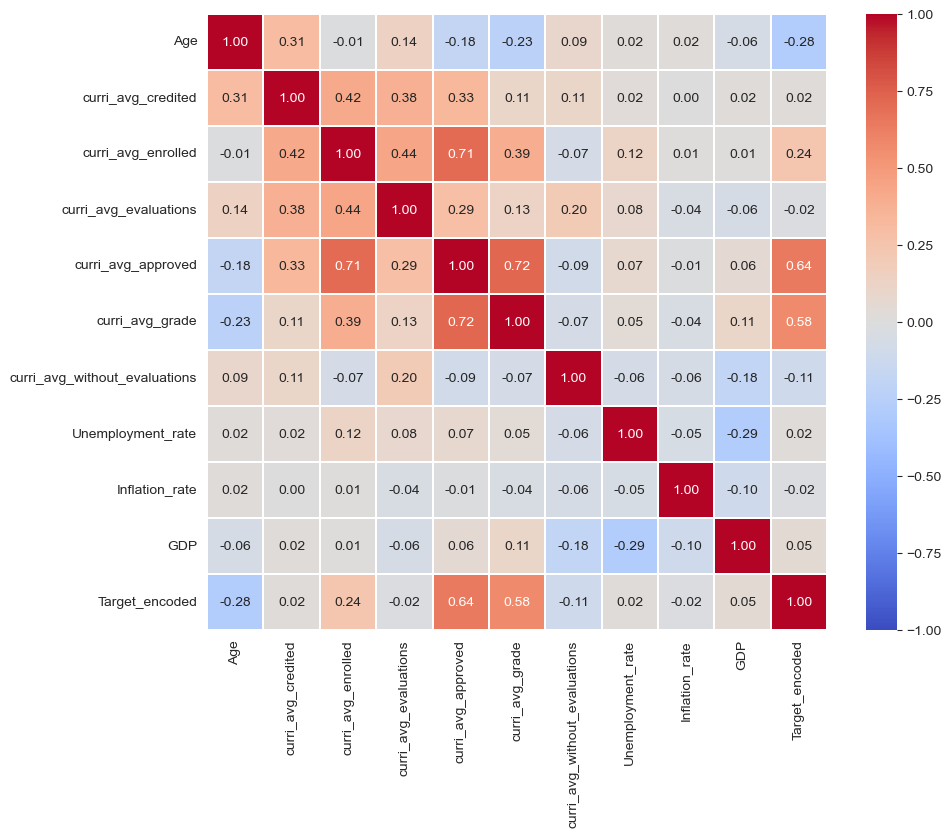

In [55]:
num_features = stud_selected[['Age', 'curri_avg_credited', 'curri_avg_enrolled', 
                              'curri_avg_evaluations', 'curri_avg_approved',
                              'curri_avg_grade', 'curri_avg_without_evaluations', 
                              'Unemployment_rate', 'Inflation_rate', 
                              'GDP', 'Target_encoded']]

plt.figure(figsize= (10, 8))
plt.rcParams.update({'font.size': 10})
sns.heatmap(num_features.corr(method = 'spearman'), vmin = -1, vmax = 1, center = 0, 
            cmap = 'coolwarm', fmt = '.2f', linewidths = .2, annot = True)

# plt.xticks(rotation=45)
plt.show()

The updated correlation matrix indicates that `curri_avg_approved` and `curri_avg_grade` maintain a relatively high correlation with the target variable (`Target_encoded`). In contrast, `curri_avg_credited` and `curri_avg_evaluations`, along with the macroeconomic data (`Unemployment_rate`, `Inflation_rate`), exhibit very low correlations, all falling between -0.02 and 0.02. Consequently, these four features will be excluded from further analysis.

Multicollinearity remains present among the academic data. This factor will be considered during model selection.

Next, the association of `curri_avg_approved` and `curri_avg_grade` with students' situations at the end of the normal course duration will be examined.


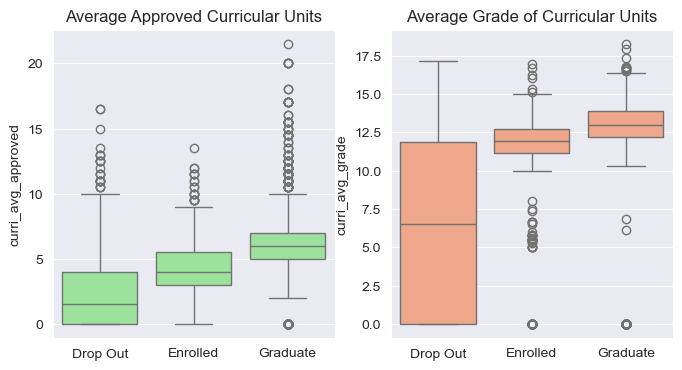

In [56]:
# Plot 'curri_avg_approved' and 'curri_avg_grade' vs. Target
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))

sns.boxplot(data = stud_selected, x = 'Target_encoded', y = 'curri_avg_approved', 
            color = 'lightgreen', ax = ax1)
ax1.set_title('Average Approved Curricular Units')
ax1.set_xlabel("")
ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels(['Drop Out', 'Enrolled', 'Graduate'])

sns.boxplot(data = stud_selected, x = 'Target_encoded', y = 'curri_avg_grade', 
            color = 'lightsalmon', ax = ax2)
ax2.set_title('Average Grade of Curricular Units')
ax2.set_xlabel("")
ax2.set_xticks([0, 1, 2])
ax2.set_xticklabels(['Drop Out', 'Enrolled', 'Graduate'])

It's not surprising that 'Graduate' is associated with more approved curricular units and higher grades. However, there are some instances of a 0 value for average grade and average approved curricular units in the 'Graduate' class.